In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

In [11]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmpBh57tz


In [12]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 0.1,
        'enemy': -0.1,
    },
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 25,
        "enemy" :  25,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.0,
    "delta_v": 50
}

In [13]:
# create the game simulator
g = KarpathyGame(current_settings)

In [15]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Tensorflow business - it is always good to reset a graph before creating a new controller.
    tf.reset_default_graph()
    session = tf.InteractiveSession()

    # This little guy will let us run tensorboard
    #      tensorboard --logdir [LOG_DIR]
    journalist = tf.train.SummaryWriter(LOG_DIR)

    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    brain = MLP([g.observation_size,], [200, 200, g.num_actions], 
                [tf.tanh, tf.tanh, tf.identity])
    
    # The optimizer to use. Here we use RMSProp as recommended
    # by the publication
    optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

    # DiscreteDeepQ object
    current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                       discount_rate=0.99, exploration_period=5000, max_experience=10000, 
                                       store_every_nth=4, train_every_nth=4,
                                       summary_writer=journalist)
    
    session.run(tf.initialize_all_variables())
    session.run(current_controller.target_network_update)
    # graph was not available when journalist was created  
    journalist.add_graph(session.graph_def)

In [16]:
FPS          = 30
ACTION_EVERY = 3
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 20
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    with tf.device("/cpu:0"):
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 disable_training=False,
                 simulation_resolution=0.001,
                 save_path=None,
                 max_frames=10000)
except KeyboardInterrupt:
    print("Interrupted")

In [17]:
session.run(current_controller.target_network_update)

In [18]:
current_controller.q_network.input_layer.Ws[0].eval()

array([[ 0.01441706, -0.02520694, -0.07593913, ...,  0.06427404,
        -0.02643774,  0.05855528],
       [ 0.0770822 ,  0.05608216, -0.066397  , ...,  0.06312007,
        -0.02823044, -0.06975941],
       [-0.05859286,  0.04606444,  0.0600163 , ..., -0.01236301,
        -0.06122607, -0.047261  ],
       ..., 
       [-0.00445661, -0.00751907, -0.03780887, ..., -0.00894008,
        -0.05594058,  0.04437672],
       [-0.02915375,  0.04142714, -0.0417085 , ..., -0.066741  ,
        -0.07433455, -0.06573054],
       [ 0.05215149, -0.06628429,  0.06427625, ...,  0.00474106,
         0.03213439, -0.04441135]], dtype=float32)

In [19]:
current_controller.target_q_network.input_layer.Ws[0].eval()

array([[ 0.01441706, -0.02520694, -0.07593913, ...,  0.06427404,
        -0.02643774,  0.05855528],
       [ 0.0770822 ,  0.05608216, -0.066397  , ...,  0.06312007,
        -0.02823044, -0.06975941],
       [-0.05859286,  0.04606444,  0.0600163 , ..., -0.01236301,
        -0.06122607, -0.047261  ],
       ..., 
       [-0.00445661, -0.00751907, -0.03780887, ..., -0.00894008,
        -0.05594058,  0.04437672],
       [-0.02915375,  0.04142714, -0.0417085 , ..., -0.066741  ,
        -0.07433455, -0.06573054],
       [ 0.05215149, -0.06628429,  0.06427625, ...,  0.00474106,
         0.03213439, -0.04441135]], dtype=float32)

# Average Reward over time

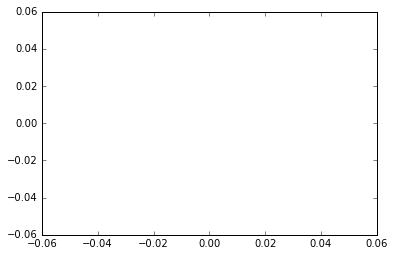

In [20]:
g.plot_reward(smoothing=100)

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [8]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-2].shape[0]//g.eye_observation_size, g.eye_observation_size)
print(x[:-2].reshape(new_shape))
print(x[-2:])
g.to_html()

[[1.00 1.00 0.34 1.00 0.52 0.53]
 [1.00 1.00 0.34 1.00 0.52 0.53]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [0.69 1.00 1.00 1.00 0.50 0.18]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.79 0.00 0.00]
 [1.00 1.00 1.00 0.68 0.00 0.00]
 [1.00 0.43 1.00 1.00 -0.00 0.54]
 [1.00 0.39 1.00 1.00 -0.00 0.54]
 [1.00 1.00 1.00 0.56 0.00 0.00]
 [1.00 1.00 1.00 0.57 0.00 0.00]
 [1.00 1.00 1.00 0.61 0.00 0.00]
 [1.00 1.00 1.00 0.68 0.00 0.00]
 [1.00 1.00 1.00 0.79 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00]
 [1.00 1

<tf_rl.utils.svg.Scene instance at 0x7f4284777fc8>